In [79]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time

In [88]:
# Fonction pour télécharger les prix d'une action
def get_stock_data(ticker, start, end):
    stock_data = yf.download(ticker, start=start, end=end)["Close"]
    return stock_data

# Visualisation des prix historiques
def plot_historical_prices(stock_prices, ticker):
    plt.figure(figsize=(12,6))
    plt.plot(stock_prices, label=f"{ticker} Prices", color="blue")
    plt.title(f"Historical Prices of {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Calcul des rendements log et des paramètres Monte Carlo
def compute_stock_metrics(stock_prices):
    log_returns = np.log(stock_prices / stock_prices.shift(1))
    mean_return = log_returns.mean()
    volatility = log_returns.std()
    return log_returns, mean_return, volatility

# Simulation Monte Carlo Annualisée
def monte_carlo_simulation_annualized(stock_prices, mean_return_annualized, volatility_annualized, days, simulations):
    last_price = float(stock_prices.iloc[-1].item())
    simulation_results = np.zeros((days, simulations))
    
    for i in range(simulations):
        daily_returns = np.random.normal(mean_return_annualized / 252, volatility_annualized / np.sqrt(252), days)
        price_series = last_price * np.exp(np.cumsum(daily_returns))
        simulation_results[:, i] = price_series
    
    return simulation_results

In [50]:
# Récupération du ticker de l'action
ticker = input("Entrez le ticker de l'action à analyser (ex: MC.PA) : ").strip().upper()

# Choix de la période de temps
start_date = input("Entrez la date de début (YYYY-MM-DD, ex: 2010-01-01) : ").strip()
end_date = input("Entrez la date de fin (YYYY-MM-DD, ex: 2024-01-01) : ").strip()

# Vérification des dates entrées
if start_date >= end_date:
    raise ValueError("La date de début doit être antérieure à la date de fin.")


In [89]:
# Récupération de la date actuelle
today = datetime.datetime.today().strftime("%Y-%m-%d")

# Vérification et récupération des prix réels après la période de simulation
real_future_prices = None
if end_date < today:
    real_future_prices = yf.download(ticker, start=end_date, end=today)["Close"]


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


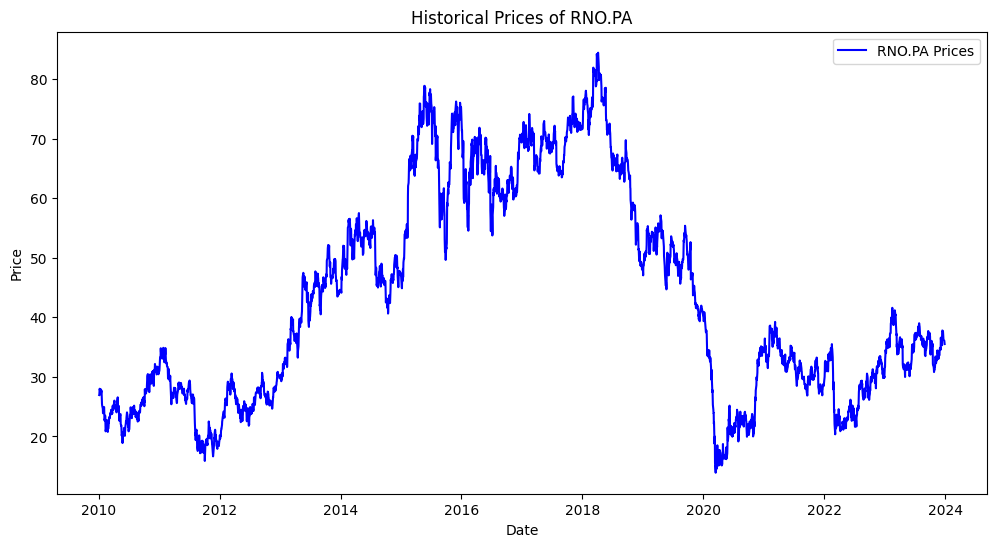

Rendements logarithmiques calculés pour RNO.PA
Moyenne des rendements : 0.000077
Volatilité annuelle : 0.397248


In [52]:
# Télécharger les données historiques
stock_prices = get_stock_data(ticker, start_date, end_date)

# Affichage des prix historiques
plot_historical_prices(stock_prices, ticker)

# Calcul des métriques
log_returns, mean_return, volatility = compute_stock_metrics(stock_prices)

# Affichage des métriques calculées
print(f"Rendements logarithmiques calculés pour {ticker}")
print(f"Moyenne des rendements : {mean_return.item():.6f}")
print(f"Volatilité annuelle : {volatility.item() * np.sqrt(252):.6f}")


In [65]:
# Demande de la durée de prévision en années
num_years = int(input("Combien d'années voulez-vous prévoir avec Monte Carlo ? (ex: 5) : "))

# Conversion en jours de trading
num_days = num_years * 252  

# Annualisation des rendements et de la volatilité
mean_return_annualized = mean_return * 252
volatility_annualized = volatility * np.sqrt(252)

# Nombre de simulations Monte Carlo
num_simulations = 10000  


In [90]:
# Exécuter la simulation Monte Carlo sur plusieurs années
simulated_prices = monte_carlo_simulation_annualized(stock_prices, mean_return_annualized, volatility_annualized, num_days, num_simulations)

# Calcul des statistiques des simulations
mean_prediction = simulated_prices.mean(axis=1)
median_prediction = np.median(simulated_prices, axis=1)
percentile_5 = np.percentile(simulated_prices, 5, axis=1)
percentile_95 = np.percentile(simulated_prices, 95, axis=1)

# Générer les dates futures
future_dates = pd.date_range(start=stock_prices.index[-1], periods=num_days + 1, freq='B')[1:]
future_dates = future_dates[:len(mean_prediction)]  # Ajuster la longueur pour correspondre aux prédictions

# Vérifier si des prix réels sont disponibles après end_date
if real_future_prices is not None and not real_future_prices.empty:
    common_dates = real_future_prices.index.intersection(future_dates)

    if not common_dates.empty:
        # Récupération des valeurs réelles et des prédictions correspondantes
        real_values = real_future_prices.loc[common_dates]
        predicted_values = pd.Series(mean_prediction[:len(real_values)], index=common_dates)

        # Nettoyage des NaN
        real_values = real_values.dropna()
        predicted_values = predicted_values.loc[real_values.index].dropna()

        # Vérification de la présence de données après nettoyage
        if len(real_values) > 0 and len(predicted_values) > 0:
            # Calcul de MAE et RMSE
            mae = mean_absolute_error(real_values, predicted_values)
            rmse = np.sqrt(mean_squared_error(real_values, predicted_values))

            # 📊 Affichage des résultats
            print(f"Fiabilité du Modèle Monte Carlo :")
            print(f"Erreur Absolue Moyenne (MAE) : {mae:.2f}")
            print(f"Root Mean Squared Error (RMSE) : {rmse:.2f}")
        else:
            print("Aucune donnée valide après suppression des NaN pour calculer les erreurs.")
    else:
        print("Pas de dates communes entre les prix réels et la prévision Monte Carlo.")
else:
    print("Pas de prix réels observés pour effectuer le calcul des erreurs.")


Fiabilité du Modèle Monte Carlo :
Erreur Absolue Moyenne (MAE) : 5.40
Root Mean Squared Error (RMSE) : 7.12


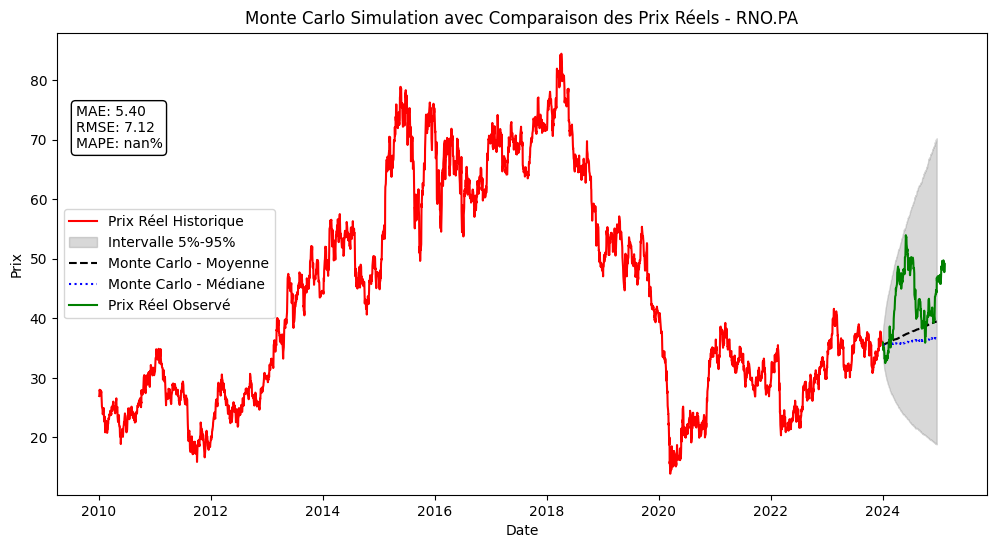

In [91]:
# Création du graphique principal
plt.figure(figsize=(12,6))

# Prix réels historiques
plt.plot(stock_prices, label="Prix Réel Historique", color="red")

# Intervalle de confiance 5%-95%
plt.fill_between(future_dates, percentile_5, percentile_95, color='gray', alpha=0.3, label="Intervalle 5%-95%")

# Moyenne des simulations Monte Carlo
plt.plot(future_dates, mean_prediction, color="black", linestyle="dashed", label="Monte Carlo - Moyenne")

# Médiane des simulations
plt.plot(future_dates, median_prediction, color="blue", linestyle="dotted", label="Monte Carlo - Médiane")

# Ajout des prix réels si disponibles après end_date
if real_future_prices is not None and not real_future_prices.empty:
    plt.plot(real_future_prices.index, real_future_prices, color="green", linestyle="solid", label="Prix Réel Observé")

# Vérifier si les erreurs existent avant de les afficher
if mae is not None and rmse is not None and mape is not None:
    error_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%"
    plt.annotate(error_text, xy=(0.02, 0.75), xycoords='axes fraction', fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# Personnalisation du graphique
plt.title(f"Monte Carlo Simulation avec Comparaison des Prix Réels - {ticker}")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.show()


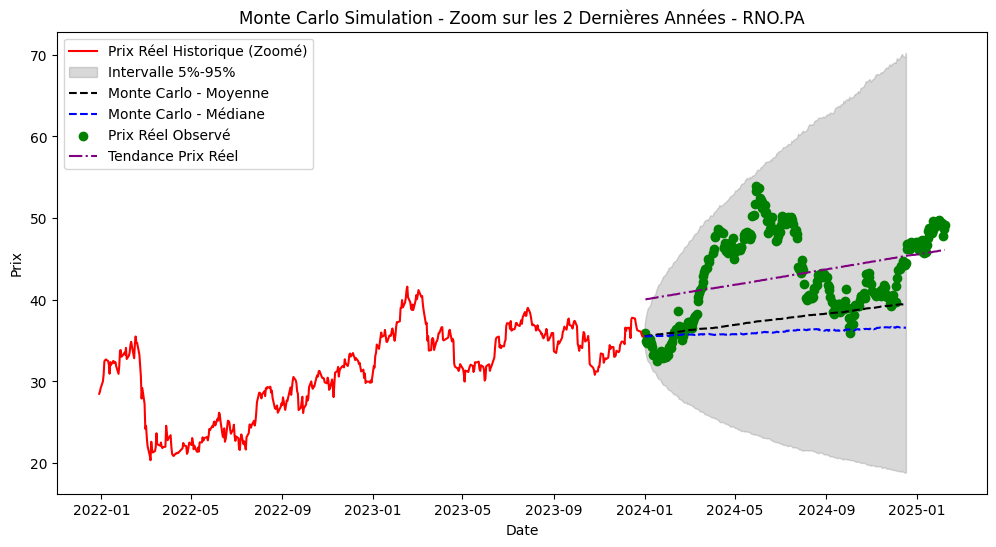

In [94]:
# Définition de la période de zoom (2 ans avant la simulation Monte Carlo)
zoom_start_date = (pd.to_datetime(stock_prices.index[-1]) - pd.DateOffset(years=2)).strftime('%Y-%m-%d')
stock_prices_zoomed = stock_prices.loc[zoom_start_date:]

# Création d'un nouveau graphique avec zoom
plt.figure(figsize=(12,6))

# Courbe des prix historiques zoomée
plt.plot(stock_prices_zoomed, label="Prix Réel Historique (Zoomé)", color="red")

# Intervalle de confiance Monte Carlo
plt.fill_between(future_dates, percentile_5, percentile_95, color='gray', alpha=0.3, label="Intervalle 5%-95%")

# Moyenne des simulations
plt.plot(future_dates, mean_prediction, color="black", linestyle="dashed", label="Monte Carlo - Moyenne")

# Médiane des simulations
plt.plot(future_dates, np.median(simulated_prices, axis=1), color="blue", linestyle="--", label="Monte Carlo - Médiane")

# Ajout des prix réels observés
if real_future_prices is not None:
    plt.scatter(real_future_prices.index, real_future_prices, color="green", marker='o', label="Prix Réel Observé")

    # Régression linéaire sur les prix réels observés
    x_real = np.array(range(len(real_future_prices))).reshape(-1, 1)
    y_real = real_future_prices.values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(x_real, y_real)
    trend_line = model.predict(x_real)
    plt.plot(real_future_prices.index, trend_line, color="purple", linestyle="dashdot", label="Tendance Prix Réel")

# Paramètres du graphique zoomé
plt.title(f"Monte Carlo Simulation - Zoom sur les 2 Dernières Années - {ticker}")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.show()
